In [17]:
from google.colab import files
uploaded = files.upload()


Saving myimage.jpeg to myimage (5).jpeg


In [18]:

load_from_path = '/content/myimage.jpeg'
load_from_base64 = None

print('Set your image path or base64 and run the next cells.')


Set your image path or base64 and run the next cells.


In [19]:

from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import io, base64, os
import math

def show_image(img, title=None):
    plt.figure(figsize=(5,5))
    if img.ndim==2:
        plt.imshow(img, cmap=None)
    else:
        plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def load_image_from_inputs(path, base64_string):

    if path and os.path.exists(path):
        img = Image.open(path).convert('RGB')
        return np.array(img)
    if base64_string:
        img_data = base64.b64decode(base64_string)
        img = Image.open(io.BytesIO(img_data)).convert('RGB')
        return np.array(img)

    H, W = 256, 256
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    gx = np.tile(x, (H,1))
    gy = np.tile(y[:,None], (1,W))
    r = (0.6 * gx + 0.4 * gy)
    g = (0.3 * gx + 0.7 * gy)
    b = (0.7 * (1-gx) + 0.3 * gy)
    img = np.stack([r,g,b], axis=2)
    cy, cx = H//2, W//2
    Y, X = np.ogrid[:H, :W]
    circle = ((X-cx)**2 + (Y-cy)**2) <= (50**2)
    img[circle, 0] = 1.0
    img[circle, 1] = 0.1
    img[circle, 2] = 0.1
    for i in range(16, W, 32):
        img[:, i:i+2, :] *= 0.6
    img_uint8 = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    pil = Image.fromarray(img_uint8)
    draw = ImageDraw.Draw(pil)
    try:
        fnt = ImageFont.load_default()
        draw.text((10, 10), 'Sample', font=fnt, fill=(255,255,255))
    except Exception:
        pass
    return np.array(pil)


## Part A — Load and convert
This cell:
- Loads the image from your `load_from_path` or `load_from_base64`
- Displays the RGB image
- Converts to grayscale using NumPy weighted sum and also (optionally) using OpenCV for comparison
- Prints shapes and some pixel values


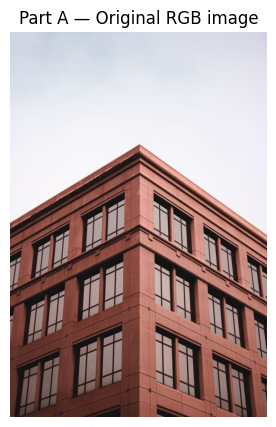

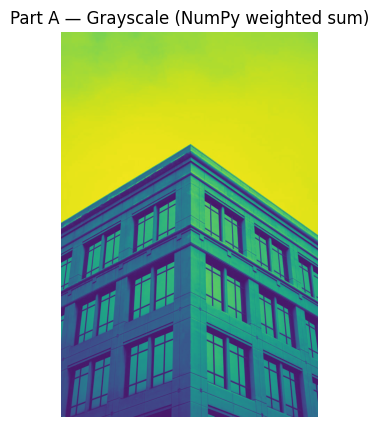

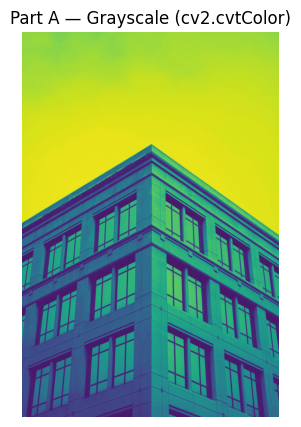

RGB shape: (1104, 736, 3)
Gray (numpy) shape: (1104, 736)
Gray (cv2) shape: (1104, 736)

Sample RGB (top-left 3x3):
[[[209 212 227]
  [209 212 227]
  [209 212 227]]

 [[209 212 227]
  [209 212 227]
  [209 212 227]]

 [[209 212 227]
  [209 212 227]
  [209 212 227]]]

Sample grayscale (top-left 3x3):
[[213 213 213]
 [213 213 213]
 [213 213 213]]


In [20]:

rgb = load_image_from_inputs(load_from_path, load_from_base64)
show_image(rgb, title='Part A — Original RGB image')

weights = np.array([0.2989, 0.5870, 0.1140])
gray_numpy = np.dot(rgb[...,:3], weights)
show_image(gray_numpy.astype(np.uint8), title='Part A — Grayscale (NumPy weighted sum)')


use_cv2 = False
try:
    import cv2
    use_cv2 = True
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    gray_cv2 = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    show_image(gray_cv2, title='Part A — Grayscale (cv2.cvtColor)')
except Exception:
    pass

print('RGB shape:', rgb.shape)
print('Gray (numpy) shape:', gray_numpy.shape)
if use_cv2:
    print('Gray (cv2) shape:', gray_cv2.shape)
print('\nSample RGB (top-left 3x3):')
print(rgb[:3,:3,:])
print('\nSample grayscale (top-left 3x3):')
print(np.round(gray_numpy[:3,:3]).astype(int))


## Part B — FFT, magnitude and phase
- Compute `fft2`, `fftshift`
- Compute magnitude and phase
- Display magnitude spectrum (use `log1p`) and phase (scaled for display)


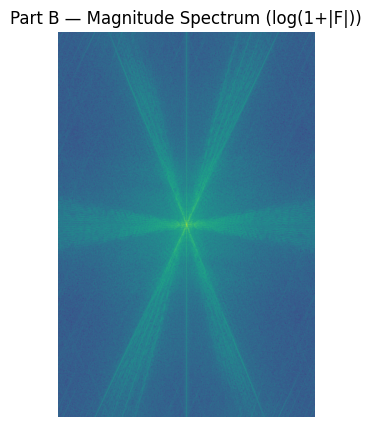

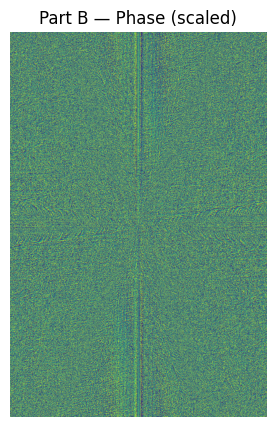

Center frequency magnitude sample (5x5):
[[  2228429   5064084  11009485   3605714   1213626]
 [  1367363   7473855  32579868   3652999   1456207]
 [   695436   6301544 123182378   6301544    695436]
 [  1456207   3652999  32579868   7473855   1367363]
 [  1213626   3605714  11009485   5064084   2228429]]


In [21]:

gray = gray_numpy.astype(np.float64)
F = np.fft.fft2(gray)
fshift = np.fft.fftshift(F)
magnitude = np.abs(fshift)
phase = np.angle(fshift)
magnitude_spectrum = np.log1p(magnitude)
show_image(magnitude_spectrum, title='Part B — Magnitude Spectrum (log(1+|F|))')
phase_disp = (phase - phase.min()) / (phase.max() - phase.min() + 1e-12) * 255
show_image(phase_disp.astype(np.uint8), title='Part B — Phase (scaled)')
H, W = gray.shape
print('Center frequency magnitude sample (5x5):')
cy, cx = H//2, W//2
print(np.round(magnitude[cy-2:cy+3, cx-2:cx+3]).astype(int))


## Part C — Filters in frequency domain
Create LPF masks (circular) with radii 10, 30, 80 (you can adapt to image size), HPF = 1-LPF, and a square LPF (side 50 centered). Reconstruct each and display.

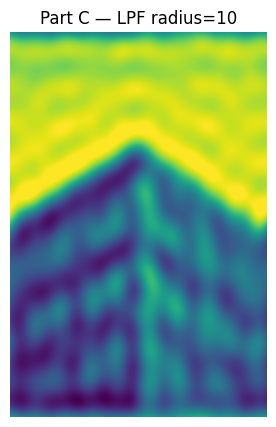

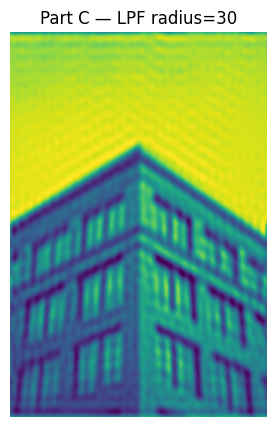

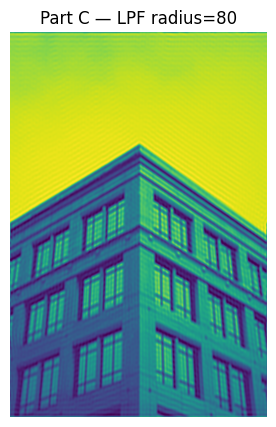

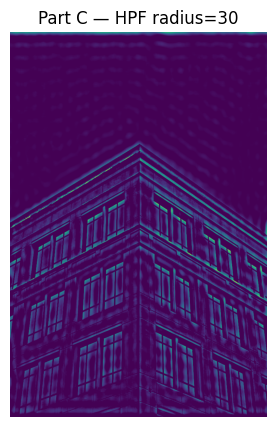

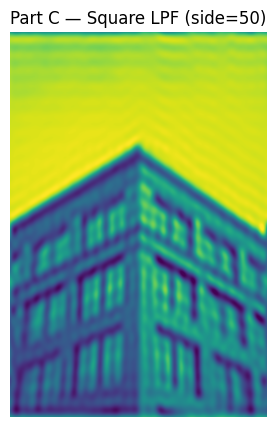

In [22]:

def circular_mask(shape, radius):
    H, W = shape
    Y, X = np.ogrid[:H, :W]
    cy, cx = H//2, W//2
    dist2 = (X-cx)**2 + (Y-cy)**2
    mask = dist2 <= radius**2
    return mask.astype(np.float64)

radii = [10, 30, 80]
for r in radii:
    mask = circular_mask(gray.shape, r)
    fshift_masked = fshift * mask
    img_back = np.real(np.fft.ifft2(np.fft.ifftshift(fshift_masked)))
    show_image(np.clip(img_back, 0, 255).astype(np.uint8), title=f'Part C — LPF radius={r}')
    # comment: smaller radius keeps only very low frequencies-more blur

# HPF
r_hpf = 30
mask_lpf = circular_mask(gray.shape, r_hpf)
mask_hpf = 1.0 - mask_lpf
img_back_hpf = np.real(np.fft.ifft2(np.fft.ifftshift(fshift * mask_hpf)))
show_image(np.clip(img_back_hpf, 0, 255).astype(np.uint8), title=f'Part C — HPF radius={r_hpf}')

# Square LPF
side = 50
mask_square = np.zeros_like(gray, dtype=np.float64)
H, W = gray.shape
cy, cx = H//2, W//2
half = side//2
mask_square[cy-half:cy+half, cx-half:cx+half] = 1.0
img_back_square = np.real(np.fft.ifft2(np.fft.ifftshift(fshift * mask_square)))
show_image(np.clip(img_back_square, 0, 255).astype(np.uint8), title='Part C — Square LPF (side=50)')


## Part D — Phase-only and Magnitude-only reconstructions
D1: Phase-only using `fshift/|fshift|` (and show equivalence with `exp(i*angle)`)
D2: Magnitude-only (phase=0) and a short note about logarithm role.

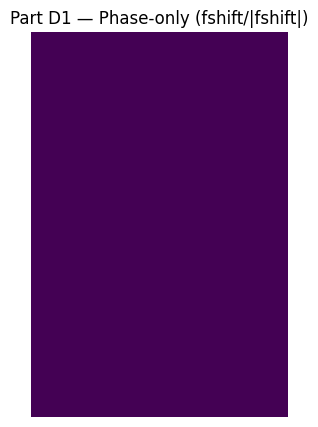

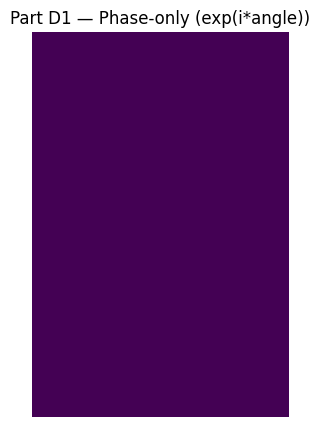

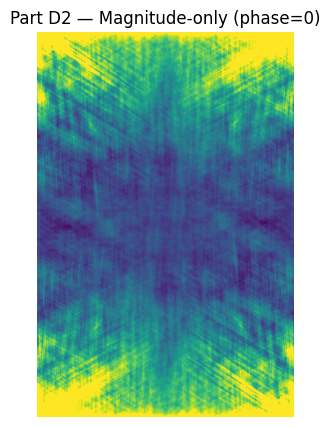

Note: np.angle returns real phase values; to reconstruct a complex spectrum use exp(1j*np.angle(...)) or fshift/|fshift|.
Logarithm (e.g. log1p) compresses dynamic range of magnitude for visualization so small but important frequencies are visible.


In [23]:

eps = 1e-12
magnitude = np.abs(fshift)
phase = np.angle(fshift)
phase_only = fshift / (magnitude + eps)
img_phase_only = np.real(np.fft.ifft2(np.fft.ifftshift(phase_only)))
show_image(np.clip(img_phase_only, 0, 255).astype(np.uint8), title='Part D1 — Phase-only (fshift/|fshift|)')

# Reconstruction from angle via exp(i*angle)
img_from_angle = np.real(np.fft.ifft2(np.fft.ifftshift(np.exp(1j * phase))))
show_image(np.clip(img_from_angle, 0, 255).astype(np.uint8), title='Part D1 — Phase-only (exp(i*angle))')

# Magnitude-only (phase = 0)
img_mag_only = np.real(np.fft.ifft2(np.fft.ifftshift(magnitude * 1.0)))
show_image(np.clip(img_mag_only, 0, 255).astype(np.uint8), title='Part D2 — Magnitude-only (phase=0)')

print('Note: np.angle returns real phase values; to reconstruct a complex spectrum use exp(1j*np.angle(...)) or fshift/|fshift|.')
print('Logarithm (e.g. log1p) compresses dynamic range of magnitude for visualization so small but important frequencies are visible.')


## Part E (Bonus) — Swap magnitude and phase between two images
Load or generate another image and swap magnitudes and phases to observe which property encodes structure vs texture.

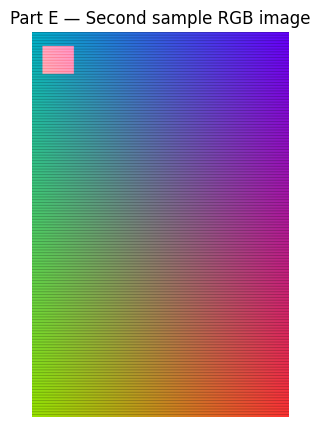

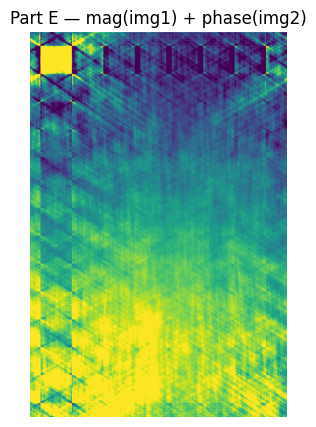

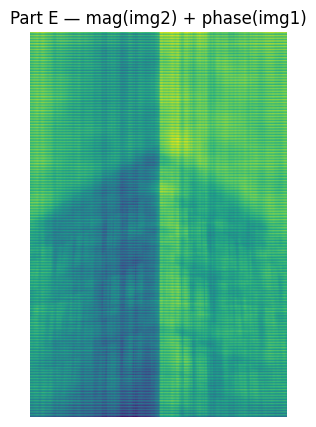


Observation: Phase carries most of the structural (edge/object) information; magnitude carries texture/contrast.


In [24]:

def generate_second_image(H=256, W=256):
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    gx = np.tile(x, (H,1))
    gy = np.tile(y[:,None], (1,W))
    r = 0.4*gx + 0.6*gy
    g = 0.7*(1-gx) + 0.2*gy
    b = 0.2*gx + 0.8*(1-gy)
    img = np.stack([r,g,b], axis=2)
    for j in range(0, H, 8):
        img[j:j+2, :, :] *= 0.7
    img[40:120, 30:120, 0] = 1.0
    return (np.clip(img, 0, 1)*255).astype(np.uint8)

rgb2 = generate_second_image(rgb.shape[0], rgb.shape[1])
show_image(rgb2, title='Part E — Second sample RGB image')

g1 = gray
F1 = np.fft.fftshift(np.fft.fft2(g1))
g2 = np.dot(rgb2[...,:3], np.array([0.2989,0.5870,0.1140])).astype(np.float64)
F2 = np.fft.fftshift(np.fft.fft2(g2))
mag1, ph1 = np.abs(F1), np.angle(F1)
mag2, ph2 = np.abs(F2), np.angle(F2)
C1 = mag1 * np.exp(1j * ph2)
C2 = mag2 * np.exp(1j * ph1)
rec1 = np.real(np.fft.ifft2(np.fft.ifftshift(C1)))
rec2 = np.real(np.fft.ifft2(np.fft.ifftshift(C2)))
show_image(np.clip(rec1, 0, 255).astype(np.uint8), title='Part E — mag(img1) + phase(img2)')
show_image(np.clip(rec2, 0, 255).astype(np.uint8), title='Part E — mag(img2) + phase(img1)')
print('\nObservation: Phase carries most of the structural (edge/object) information; magnitude carries texture/contrast.')
